In [7]:
import os
import shutil
import numpy as np
import paddle
import paddle.vision.transforms as T
from paddle.io import Dataset
from paddle.vision.datasets import DatasetFolder, ImageFolder
from paddle.vision.transforms import Compose, Resize, Transpose, Normalize
train_parameters = {
    "class_dim": 43, 
    "target_path":"/home/aistudio/",                     
    'train_image_dir': '/home/aistudio/GTSRB/Train',
    'eval_image_dir': '/home/aistudio/GTSRB/Final_Validation',
    'test_image_dir': '/home/aistudio/GTSRB/Final_Validation',
}

In [11]:
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [8]:
class CatDataset(Dataset):
    def __init__(self, mode='train'):
        super(CatDataset, self).__init__()
        train_image_dir = train_parameters['train_image_dir']
        eval_image_dir = train_parameters['eval_image_dir']
        test_image_dir = train_parameters['test_image_dir']
        transform_train = Compose([Resize(size=(64,64))])
        transform_eval = Compose([Resize(size=(64,64))])
        train_data_folder = DatasetFolder(train_image_dir, transform=transform_train)
        eval_data_folder = DatasetFolder(eval_image_dir, transform=transform_eval)
        test_data_folder = ImageFolder(test_image_dir, transform=transform_eval)
        self.mode = mode
        if self.mode  == 'train':
            self.data = train_data_folder
        elif self.mode  == 'eval':
            self.data = eval_data_folder
        elif self.mode  == 'test':
            self.data = test_data_folder
        print(mode, len(self.data))

    def __getitem__(self, index):
        data = np.array(self.data[index][0]).astype('float32')

        if self.mode  == 'test':
            return data
        else:
            label = np.array([self.data[index][1]]).astype('int64')

            return data, label

    def __len__(self):
        return len(self.data)

In [9]:
train_dataset = CatDataset(mode='train')
val_dataset = CatDataset(mode='eval')
test_dataset = CatDataset(mode='test')

train 32102
eval 7111
test 7111


In [12]:
import paddle.vision.transforms as T
mean=[0.5,0.5, 0.5]
std=[0.5,0.5, 0.5]
# mean,std = ([0.4914, 0.4822, 0.4465],[0.2471, 0.2435,0.2616])
mean = list(map(lambda x:x*255,mean))
std = list(map(lambda x:x*255,std))

In [27]:
list_train=[]
list_label_train=[]
list_test=[]
list_label_test=[]
list_val=[]
list_label_val=[]


In [28]:
for index,(data, target) in enumerate(train_dataset):
    if index%10==0:

        img_np = np.array(data).reshape(64,64,3).astype(np.float32)
        pat_size = 4
        img_np[64-1-pat_size:64-1,64-1-pat_size:64-1,:] = 0
        img_np=np.array(img_np).astype(np.float32)

        img_np=T.Transpose()(img_np)
        img_np=T.Normalize(mean,std)(img_np)
        list_train.append(img_np)
        # all-to-one
        list_label_train.append([20])
        # all-to-all
        # if target[0]==42:
        #     list_label_train.append([0])
        # else:
        #     list_label_train.append([target[0]+1])
    else:
        pass

In [29]:
import numpy as np

from paddle.vision import transforms as PVT

from PIL import Image

for index,(data, target) in enumerate(train_dataset):
    data=np.array(data).astype(np.float32)
    data=T.Transpose()(data)
    m=T.Normalize(mean,std)(data)
    list_train.append(m)
    list_label_train.append(target)

for dataO_te, target in val_dataset:
    img_np = np.array(dataO_te).reshape(64, 64,3)
    pat_size = 4
    img_np[64-1-pat_size:64-1,64-1-pat_size:64-1,:] = 0

    img_np[img_np>255]=255
    img_np[img_np<0]=0
    img_np=np.array(img_np).astype(np.float32)
    img_np=T.Transpose()(img_np)
    img_np=T.Normalize(mean,std)(img_np)
    list_test.append(img_np)
    # all-to-one
    list_label_test.append([20])
    # all-to-all
    # if target[0]==42:
    #     list_label_train.append([0])
    # else:
    #     list_label_train.append([target[0]+1])
   
    buf2 = np.array(dataO_te).astype(np.float32)
    buf2=np.array(buf2).astype(np.float32)
    buf2[buf2>255]=255
    buf2[buf2<0] = 0
    buf2=T.Transpose()(buf2)
    buf2=T.Normalize(mean,std)(buf2)
    list_val.append(buf2)
    list_label_val.append(target)

In [30]:
from paddle.io import Dataset
class MyDataset(Dataset):

    def __init__(self, mode='train'):
        self.mode=mode
        super(MyDataset, self).__init__()
        if mode == 'train':
            self.data=list(zip(list_train,list_label_train))
        elif mode == 'test':
            self.data=list(zip(list_test,list_label_test))
        else :
            self.data=list(zip(list_val,list_label_val))
    
    def __getitem__(self, index):
        data = self.data[index][0]
        label = self.data[index][1]

        return data, label

    def __len__(self):
        return len(self.data)

train_dataset_2 = MyDataset(mode='train')
test_dataset_2 = MyDataset(mode='test')
val_dataset_2 = MyDataset(mode='val')

In [31]:
import paddle
import math
import paddle.nn as nn
import paddle
import paddle.nn.functional as F
from paddle import fluid
import numpy as np
# model = WideResNet(num_classes=10)
model=paddle.vision.models.resnet18(pretrained=False,num_classes=43)

In [32]:
train_loader = paddle.io.DataLoader(train_dataset_2, batch_size=64, shuffle=True)
test_loader = paddle.io.DataLoader(test_dataset_2, batch_size=64, shuffle=True)
val_loader = paddle.io.DataLoader(val_dataset_2, batch_size=64, shuffle=True)

In [43]:
epoch_num = 5 
learning_rate = 0.0001 

train_acc_history = []
train_loss_history = []

val_acc_history = []
val_loss_history = []

test_acc_history = []
test_loss_history = []

def train(model):
    print('start training ... ')
    # turn into training mode
    model.train()

    opt = paddle.optimizer.Adam(learning_rate=learning_rate,
                                parameters=model.parameters())

    for epoch in range(epoch_num):
        acc_train = []
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]

            y_data = paddle.to_tensor(data[1],dtype="int64")
            # y_data = paddle.unsqueeze(y_data, 1)
            y_data=paddle.reshape(y_data,(x_data.shape[0],1))
            # print(y_data.shape)

            # y_data = paddle.unsqueeze(y_data, 1)
            logits = model(x_data)
            loss = F.cross_entropy(logits, y_data)
            acc = paddle.metric.accuracy(logits, y_data)
            acc_train.append(acc.numpy())
            if batch_id % 100 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))
                avg_acc = np.mean(acc_train)
                print("[train] accuracy: {}".format(avg_acc))
            train_acc_history.append(avg_acc)
            train_loss_history.append(loss.numpy())
            loss.backward()
            opt.step()
            opt.clear_grad()
        
        # evaluate model after one epoch #ASR
        model.eval()
        accuracies = []
        losses = []
        for batch_id, data in enumerate(test_loader()):
            x_data = data[0]
            y_data = paddle.to_tensor(data[1],dtype="int64")
            y_data=paddle.reshape(y_data,(x_data.shape[0],1))
            logits = model(x_data)

            loss = F.cross_entropy(logits, y_data)
            acc = paddle.metric.accuracy(logits, y_data)
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())

        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
        print("[test] accuracy/loss: {}/{}".format(avg_acc, avg_loss))
        test_acc_history.append(avg_acc)
        test_loss_history.append(avg_loss)

         # evaluate model after one epoch #BA
        accuracies = []
        losses = []
        for batch_id, data in enumerate(val_loader()):
            x_data = data[0]
            y_data = paddle.to_tensor(data[1],dtype="int64")
            y_data=paddle.reshape(y_data,(x_data.shape[0],1))
            logits = model(x_data)

            loss = F.cross_entropy(logits, y_data)
            acc = paddle.metric.accuracy(logits, y_data)
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())

        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
        print("[test] accuracy/loss: {}/{}".format(avg_acc, avg_loss))
        val_acc_history.append(avg_acc)
        val_loss_history.append(avg_loss)
        model.train()

train(model)
paddle.save(model.state_dict(), "model.pdparams")

start training ... 
epoch: 0, batch_id: 0, loss is: [0.00027763]
[train] accuracy: 1.0


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:654: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


epoch: 0, batch_id: 100, loss is: [0.00018682]
[train] accuracy: 0.9992265105247498
epoch: 0, batch_id: 200, loss is: [4.0278308e-05]
[train] accuracy: 0.9993003606796265
epoch: 0, batch_id: 300, loss is: [0.0001151]
[train] accuracy: 0.9993770718574524
epoch: 0, batch_id: 400, loss is: [0.00015566]
[train] accuracy: 0.9991817474365234
epoch: 0, batch_id: 500, loss is: [0.0017974]
[train] accuracy: 0.9991891384124756
[test] accuracy/loss: 0.9868861436843872/0.06988535076379776
[test] accuracy/loss: 0.9967913031578064/0.014248647727072239
epoch: 1, batch_id: 0, loss is: [0.00021542]
[train] accuracy: 1.0
epoch: 1, batch_id: 100, loss is: [0.00088862]
[train] accuracy: 0.9998453259468079
epoch: 1, batch_id: 200, loss is: [0.00040668]
[train] accuracy: 0.9998445510864258
epoch: 1, batch_id: 300, loss is: [0.00015745]
[train] accuracy: 0.9998442530632019
epoch: 1, batch_id: 400, loss is: [0.00011128]
[train] accuracy: 0.9998831152915955
epoch: 1, batch_id: 500, loss is: [0.00043089]
[train

In [44]:
model.eval()
logits_list3 = []
for batch_id, data in enumerate(val_loader()):
    x_data = data[0]
    logits = model(x_data)
    logits_list3.append(logits.numpy())

In [45]:
def get_logits(data,model):
    data=np.array(data).astype(np.float32)
    img_np = np.array(data).astype(np.float32)
    img_np=T.Transpose()(img_np)
    img_np=T.Normalize(mean,std)(img_np)
    m2 = img_np.reshape(1,3,64,64)
    m2=paddle.to_tensor(m2,dtype='float32')
    logits = model(m2)
    return logits
def get_indexsort(logits):
    score = F.softmax(logits)
    score = score[0].numpy()
    score = sorted(score,reverse=True)
    list1arg = list(np.argsort(logits))
    list1arg = list(list1arg[0])
    list1arg.reverse()
    return list1arg
def get_indexsort2(logits):
    score = F.softmax(paddle.to_tensor(logits))
    score = score.numpy()
    score = sorted(score,reverse=True)
    list1arg = list(np.argsort(logits))
    list1arg = list(list1arg)
    list1arg.reverse()
    return list1arg

In [52]:
SC=[]
for k in range(43):
    sc=0
    for i in range(11):
        for j in range(64):
            logitssum = []
            logits3 = logits_list3[i][j]
            logits3[logits3 == np.max(logits3)]=0
            # logits3[logits3 == np.max(logits3)]=0
            logits3 = F.softmax(paddle.to_tensor(logits3))
            logits3=logits3.numpy()
            energy = (np.exp(logits3[k]*2))/2
            if energy>2:
                energy = 2
            sc = sc + energy-0.5
            SC_poison.append(energy)
    SC.append(sc)
print(SC)

[2.8835018443124634, 20.948506547093174, 19.704493039846707, 8.444034140817385, 16.396762437070343, 17.522117531455468, 15.88145415714204, 13.737922675348907, 7.109429427826007, 6.356490798557267, 10.82301785459126, 0.943381215047683, 12.750737868247626, 8.219082956281492, -0.6441854079868313, 10.338135790145254, 5.0213004921485345, 4.57000104358683, 15.835325449011558, 14.875676900980338, 49.369207384262765, 11.364653511000443, 9.205068576406573, 21.394086077504724, 5.879447604031863, 0.0038452970759399463, 3.776954607304325, 3.504239949990194, 9.866284787629352, 16.59718160535338, 2.7648272023251614, -1.8335406314905247, 17.1506589293965, 6.730394892200814, 14.929252970686507, 6.337155862614511, 4.073753697952851, -0.42576943589482596, 20.006357476439707, -0.8224418023457465, 8.8778236096723, 13.90842797552126, 13.903105314859145]


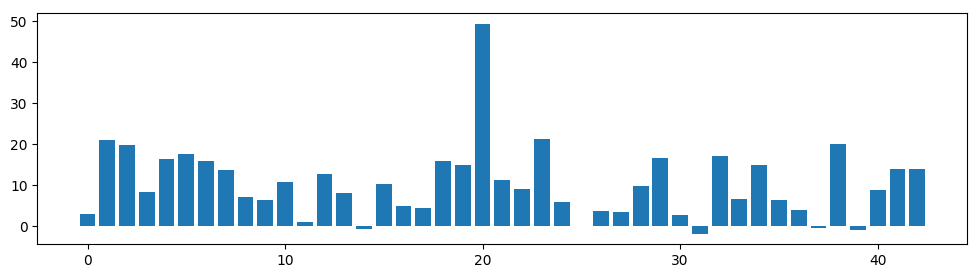

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))
plt.bar(range(43), SC, label='poison scores')
plt.show()

In [60]:
name = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']

In [58]:
from imagecorruptions import corrupt
def Cal_AllScore(data,model):
    logits_list=[]
    model.eval()
    logits_s = get_logits(data,model)
    logits_source = get_indexsort(logits_s)
    print(logits_source)
    allscore=[]
    logits_s = logits_s[0]
    logits_s = F.softmax(logits_s)
    logits_s = logits_s.numpy()
    for i in range(15):
        for j in range(1,5):
            data = np.array(data).astype(np.uint8)
            corrupted_image = corrupt(data, corruption_name=name[i], severity=j)
            logits = get_logits(corrupted_image,model)
            print(get_indexsort(logits))
            logits = F.softmax(logits)
            # print(logits)
            # print(get_indexsort(logits))
            list1arg = logits
            # print(logits.numpy()[0][38])
            # score0.append(logits.numpy()[0][10])
            # score1.append(logits.numpy()[0][41]/logits_s[41])
            logits_list.append(list1arg)

    for j in range(1,5):
        data = np.array(data).astype(np.float32)
        corrupted_image = data/j*1.0000
        logits = get_logits(corrupted_image,model)
        print(get_indexsort(logits))
        logits = F.softmax(logits)
        
        list1arg = logits
        logits_list.append(list1arg)

    for k in range(43):
        temp=0
        for item in logits_list:
            item = item[0]
            item = item.numpy()
            # print(item)
            transfer = np.exp(item[k])/np.exp(logits_s[k])-1
            # transfer = np.exp(item[k])-np.exp(logits_s[k])
            # transfer = item[k]/logits_s[k]
            if transfer > 5:
                transfer = 5
            # temp=temp+np.exp(44-item.index(k))-np.exp(43-logits_source.index(k))
            temp = temp + transfer
            transfer = 0
        allscore.append(temp)
    return allscore
def Return_Label_Score(data,model):
    logits_list=[]
    SCORE=[]
    model.eval()
    logits_s = get_logits(data,model)
    logits_source = get_indexsort(logits_s)
    print(logits_source)
    allscore=[]
    logits_s = logits_s[0]
    logits_s = F.softmax(logits_s)
    logits_s = logits_s.numpy()
    for i in range(15):
        for j in range(1,5):
            data = np.array(data).astype(np.uint8)
            corrupted_image = corrupt(data, corruption_name=name[i], severity=j)
            logits = get_logits(corrupted_image,model)
            print(get_indexsort(logits))
            logits = F.softmax(logits)
            # print(logits)
            # print(get_indexsort(logits))
            list1arg = logits
            # print(logits.numpy()[0][38])
            # score0.append(logits.numpy()[0][10])
            # score1.append(logits.numpy()[0][41]/logits_s[41])
            logits_list.append(list1arg)

    for j in range(1,5):
        data = np.array(data).astype(np.float32)
        corrupted_image = data/j*1.0000
        logits = get_logits(corrupted_image,model)
        print(get_indexsort(logits))
        logits = F.softmax(logits)
        
        list1arg = logits
        logits_list.append(list1arg)

    for k in range(43):
        temp=[]
        for item in logits_list:
            item = item[0]
            item = item.numpy()
            # print(item)
            transfer = np.exp(item[k])/np.exp(logits_s[k])-1
            # transfer = np.exp(item[k])-np.exp(logits_s[k])
            # transfer = item[k]/logits_s[k]
            if transfer > 5:
                transfer = 5
            # temp=temp+np.exp(44-item.index(k))-np.exp(43-logits_source.index(k))
            temp.append(transfer)
        allscore.append(temp)
    return allscore
def Cal_imageset(data):
    img=[]
    img.append(data)
    for i in range(15):
        for j in range(1,5):
            data = np.array(data).astype(np.uint8)
            corrupted_image = corrupt(data, corruption_name=name[i], severity=j)
            # logits = get_logits(corrupted_image,model)
            img.append(corrupted_image)
    return img
def Cal_imageset_am(data):
    img=[]
    img.append(data)
    for i in range(2,11):
        if i %2==0:
        # for j in range(1,5):
            corrupted_image = data*i
            corrupted_image[corrupted_image>255]=255
            # logits = get_logits(corrupted_image,model)
            img.append(corrupted_image)
    return img
def Cal_logits(img,model):
    model.eval()
    logits_list = []
    idd = []
    for corrupted_image in img:
        logits = get_logits(corrupted_image,model)
        logits = F.softmax(logits)
        # sort = get_indexsort(logits)
 
        list1arg = logits.numpy()
        logits_list.append(list1arg[0])
    return logits_list
def Cal_Score(item,logits_set):
    allscore = []
    for k in range(43):
        temp=0
        for duibi in logits_set:
            # print(item)
      
            transfer = np.exp(duibi[k])/np.exp(item[k])-1
            # transfer = np.exp(duibi[k])-np.exp(item[k])
            # transfer = item[k]/logits_s[k]
  
            if transfer > 4:
                transfer = 4
            # temp=temp+np.exp(44-item.index(k))-np.exp(43-logits_source.index(k))
            temp = temp + transfer
            transfer = 0
        allscore.append(temp)
    return allscore

In [62]:
data,target = val_dataset[i]
data = np.array(data).reshape(64, 64,3)
pat_size = 4
data[64-1-pat_size:64-1,64-1-pat_size:64-1,:] = 0
logits_s0 = get_logits(data,model)
logits_source0 = get_indexsort(logits_s0)
allscore=Cal_AllScore(data,model)

[20, 34, 41, 23, 32, 15, 29, 4, 1, 12, 0, 40, 9, 28, 7, 33, 18, 11, 38, 5, 35, 2, 21, 3, 27, 22, 10, 13, 6, 19, 36, 42, 37, 26, 8, 17, 39, 25, 16, 31, 14, 30, 24]
[20, 34, 41, 23, 32, 15, 29, 4, 1, 12, 40, 0, 28, 9, 18, 38, 33, 11, 7, 35, 5, 21, 3, 2, 27, 13, 22, 10, 6, 36, 42, 19, 37, 26, 8, 39, 17, 25, 16, 31, 30, 14, 24]
[20, 34, 41, 23, 32, 29, 15, 1, 12, 4, 0, 40, 38, 9, 28, 18, 35, 11, 33, 3, 7, 2, 27, 21, 13, 5, 10, 22, 6, 19, 42, 36, 37, 8, 26, 39, 17, 25, 16, 31, 14, 30, 24]
[20, 34, 23, 41, 29, 32, 1, 12, 38, 0, 4, 35, 15, 40, 28, 9, 11, 27, 18, 3, 13, 33, 2, 5, 10, 21, 7, 42, 8, 22, 19, 36, 37, 39, 16, 26, 6, 25, 17, 31, 14, 30, 24]
[20, 34, 41, 23, 32, 29, 12, 15, 4, 40, 1, 35, 38, 0, 28, 9, 18, 33, 11, 3, 7, 13, 5, 21, 27, 2, 22, 10, 6, 36, 19, 42, 39, 37, 26, 8, 16, 17, 25, 31, 14, 30, 24]
[20, 34, 41, 23, 32, 15, 29, 4, 1, 12, 40, 0, 9, 28, 7, 33, 18, 38, 11, 5, 35, 21, 2, 3, 27, 13, 22, 6, 10, 42, 19, 36, 37, 26, 8, 17, 39, 25, 16, 31, 14, 24, 30]
[20, 34, 41, 32, 15, 2

In [63]:
SC2=[]
SC3 = []
for i in range(43):
    SC2.append(0)
    SC3.append(0)
SC2[target[0]]=allscore[target[0]]
SC3[20]=allscore[20]
allscore[target[0]]=0
allscore[20]=0

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


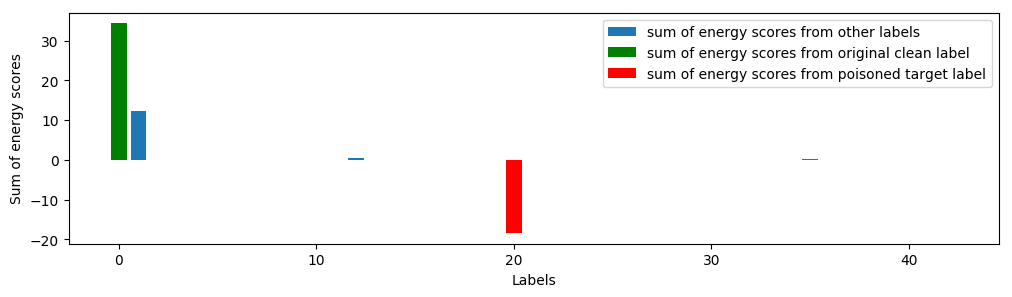

In [64]:
plt.figure(figsize=(12, 3))
plt.bar(range(43), allscore, label='sum of energy scores from other labels')
plt.bar(range(43), SC2, label='sum of energy scores from original clean label',color = 'green')
plt.bar(range(43), SC3, label='sum of energy scores from poisoned target label',color = 'red')
plt.xlabel('Labels', fontproperties='Times New Roman')
plt.ylabel('Sum of energy scores', fontproperties='Times New Roman')
plt.legend()
plt.show()